# 1 データの前処理

## 1-1 ライブラリの読み込み 

In [15]:
import pandas as pd
import numpy as np
import glob
import os

## 1-2 生育調査記録データの読み込みと成型

In [16]:
growth_path = "data/tsuji/生育調査記録_辻様.xlsx"
df_growth = pd.read_excel(growth_path, skiprows=5)
df_growth.head()

C:\Users\hayato\Documents\projects\green-onion\venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,生産者名,作物名,作,圃場名,株番号,段,記録対象,記録対象単位,実績値（値）,実績値（年月日）,品種
0,辻直也,青ネギ,24-1,９号棟,1,NaN,定植,NaN,NaN,2024-08-01,SK-4_527
1,辻直也,青ネギ,24-1,９号棟,1,NaN,草丈,cm,10.0,2024-08-02,SK-4_527
2,辻直也,青ネギ,24-1,９号棟,2,NaN,定植,NaN,NaN,2024-08-01,SK-4_527
3,辻直也,青ネギ,24-1,９号棟,2,NaN,草丈,cm,10.0,2024-08-02,SK-4_527
4,辻直也,青ネギ,24-1,９号棟,3,NaN,定植,NaN,NaN,2024-08-01,SK-4_527


In [17]:
print(df_growth.columns)

Index(['生産者名', '作物名', '作', '圃場名', '株番号', '段', '記録対象', '記録対象単位', '実績値（値）',
       '実績値（年月日）', '品種'],
      dtype='object')


### 草丈のみ抽出

In [18]:
df_growth = df_growth[df_growth["記録対象"] == "草丈"]
df_growth = df_growth[["実績値（年月日）", "株番号", "圃場名", "実績値（値）"]].rename(columns={
    "実績値（年月日）": "date",
    "実績値（値）": "height_cm",
    "圃場名": "field_name"
})
df_growth["date"] = pd.to_datetime(df_growth["date"])

### 株番号、圃場ごとに成長差分を算出（＝本日の成長量）

In [19]:
df_growth["growth_delta"] = df_growth.groupby(["field_name", "株番号"])["height_cm"].diff()

In [20]:
df_growth.head()

,date,株番号,field_name,height_cm,growth_delta
1,2024-08-02,1,９号棟,10.0,NaN
3,2024-08-02,2,９号棟,10.0,NaN
5,2024-08-02,3,９号棟,10.0,NaN
7,2024-08-09,1,９号棟,18.0,8.0
9,2024-08-09,2,９号棟,18.0,8.0


### 成長量（前日との差分）を計算

In [21]:
df_growth["growth_delta"] = df_growth.groupby("株番号")["height_cm"].diff()
df_growth.reset_index(drop=True, inplace=True)

In [22]:
df_growth.head()

,date,株番号,field_name,height_cm,growth_delta
0,2024-08-02,1,９号棟,10.0,NaN
1,2024-08-02,2,９号棟,10.0,NaN
2,2024-08-02,3,９号棟,10.0,NaN
3,2024-08-09,1,９号棟,18.0,8.0
4,2024-08-09,2,９号棟,18.0,8.0


## 1-3 環境データの読み込みと日単位に集計

### 環境データファイルの統合

In [23]:
# 対象CSVのパスを取得
csv_files = glob.glob("data/tsuji/*.csv")

# 各CSVを読み込んでDataFrameのリストに
env_list = []
for file in csv_files:
    env = pd.read_csv(file, encoding="cp932", parse_dates=["日付"])
    env["ファイル名"] = os.path.basename(file)  # 元ファイル名を追加しておくと便利
    env_list.append(env)

# すべて結合
df_env = pd.concat(env_list, ignore_index=True)

In [24]:
# 日付、時刻の変換や不要行削除
df_env["日付"] = pd.to_datetime(df_env["日付"], format="%Y/%m/%d", errors="coerce")
df_env["時刻"] = df_env["時刻"].astype(str).str.replace("*", "", regex=False)
df_env["時刻"] = pd.to_datetime(df_env["時刻"], format="%H:%M", errors="coerce").dt.time

# 全NaN列の削除
df_env = df_env.dropna(axis=1, how="all")

# すべてが0の列の削除
df_env = df_env.loc[:, ~(df_env == 0).all()]

In [25]:
print(df_env.shape)
print(df_env.dtypes)
df_env.head()

(1051429, 12)
日付                 datetime64[ns]
時刻                         object
PF 測定 気温                  float64
湿度                        float64
CO2濃度                       int64
照度                          int64
日射量                         int64
飽差                        float64
温度センサープラス１(OP1)           float64
露点                        float64
積算日射量                     float64
ファイル名                      object
dtype: object


,日付,時刻,PF 測定 気温,湿度,CO2濃度,照度,日射量,飽差,温度センサープラス１(OP1),露点,積算日射量,ファイル名
0,2024-08-02,09:11:00,34.2,72.9,444,27,273,10.3,34.4,28.6,0.01638,p0005211_環境データ_12号棟_202408.csv
1,2024-08-02,09:12:00,34.3,72.0,442,27,270,10.7,34.4,28.5,0.03258,p0005211_環境データ_12号棟_202408.csv
2,2024-08-02,09:13:00,34.4,71.5,443,19,192,10.9,34.3,28.5,0.04410,p0005211_環境データ_12号棟_202408.csv
3,2024-08-02,09:14:00,34.5,68.6,442,28,280,12.1,34.4,27.9,0.06090,p0005211_環境データ_12号棟_202408.csv
4,2024-08-02,09:15:00,34.4,69.0,442,25,253,11.9,34.3,27.9,0.07608,p0005211_環境データ_12号棟_202408.csv


In [26]:
df_env.describe()

,日付,PF 測定 気温,湿度,CO2濃度,照度,日射量,飽差,温度センサープラス１(OP1),露点,積算日射量
count,1051429,1.051429e+06,1.051429e+06,1.051429e+06,1.051429e+06,1.051429e+06,1.051429e+06,1.051429e+06,1.051429e+06,1.051429e+06
mean,2024-11-01 04:37:15.198001408,1.820333e+01,8.101930e+01,4.368461e+02,7.208096e+00,7.412727e+01,3.980739e+00,1.841344e+01,1.457405e+01,3.236350e+00
min,2024-08-02 00:00:00,1.800000e+00,2.720000e+01,1.420000e+02,0.000000e+00,0.000000e+00,3.000000e-01,9.200000e+00,-4.900000e+00,0.000000e+00
25%,2024-09-17 00:00:00,9.500000e+00,7.360000e+01,4.120000e+02,0.000000e+00,0.000000e+00,1.000000e+00,1.350000e+01,6.900000e+00,0.000000e+00
50%,2024-11-01 00:00:00,1.780000e+01,8.620000e+01,4.370000e+02,0.000000e+00,0.000000e+00,1.800000e+00,1.970000e+01,1.430000e+01,2.078280e+00
75%,2024-12-17 00:00:00,2.550000e+01,9.100000e+01,4.590000e+02,1.000000e+01,1.040000e+02,5.100000e+00,2.260000e+01,2.300000e+01,5.170440e+00
max,2025-01-31 00:00:00,4.270000e+01,9.750000e+01,6.080000e+02,1.240000e+02,1.242000e+03,3.660000e+01,3.590000e+01,3.090000e+01,2.396124e+01
std,NaN,9.098617e+00,1.341100e+01,3.914404e+01,1.342614e+01,1.355789e+02,4.820445e+00,4.489041e+00,7.979423e+00,3.902642e+00


In [27]:
df_env.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051429 entries, 0 to 1051428
Data columns (total 12 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   日付               1051429 non-null  datetime64[ns]
 1   時刻               1051429 non-null  object        
 2   PF 測定 気温         1051429 non-null  float64       
 3   湿度               1051429 non-null  float64       
 4   CO2濃度            1051429 non-null  int64         
 5   照度               1051429 non-null  int64         
 6   日射量              1051429 non-null  int64         
 7   飽差               1051429 non-null  float64       
 8   温度センサープラス１(OP1)  1051429 non-null  float64       
 9   露点               1051429 non-null  float64       
 10  積算日射量            1051429 non-null  float64       
 11  ファイル名            1051429 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(3), object(2)
memory usage: 96.3+ MB


### 環境データを日単位に集計

In [28]:
df_env["datetime"] = pd.to_datetime(df_env["日付"].astype(str) + " " + df_env["時刻"].astype(str))
df_env["date"] = df_env["datetime"].dt.date
df_env["date"] = pd.to_datetime(df_env["date"])

In [29]:
df_env.head()

,日付,時刻,PF 測定 気温,湿度,CO2濃度,照度,日射量,飽差,温度センサープラス１(OP1),露点,積算日射量,ファイル名,datetime,date
0,2024-08-02,09:11:00,34.2,72.9,444,27,273,10.3,34.4,28.6,0.01638,p0005211_環境データ_12号棟_202408.csv,2024-08-02 09:11:00,2024-08-02
1,2024-08-02,09:12:00,34.3,72.0,442,27,270,10.7,34.4,28.5,0.03258,p0005211_環境データ_12号棟_202408.csv,2024-08-02 09:12:00,2024-08-02
2,2024-08-02,09:13:00,34.4,71.5,443,19,192,10.9,34.3,28.5,0.04410,p0005211_環境データ_12号棟_202408.csv,2024-08-02 09:13:00,2024-08-02
3,2024-08-02,09:14:00,34.5,68.6,442,28,280,12.1,34.4,27.9,0.06090,p0005211_環境データ_12号棟_202408.csv,2024-08-02 09:14:00,2024-08-02
4,2024-08-02,09:15:00,34.4,69.0,442,25,253,11.9,34.3,27.9,0.07608,p0005211_環境データ_12号棟_202408.csv,2024-08-02 09:15:00,2024-08-02


### 日別に平均・合計で集計

In [30]:
df_env_daily = df_env.groupby("date").agg({
    "PF 測定 気温": "mean",
    "湿度": "mean",
    "CO2濃度": "mean",
    "照度": "mean",
    "日射量": "sum",
    "飽差": "mean",
    "露点": "mean",
    "積算日射量": "max"
}).reset_index()

## 1-4 生育データと環境データの結合と特徴量生成

In [31]:
df = pd.merge(df_growth, df_env_daily, on="date", how="left")

### 翌日の成長量を目標変数として追加

In [44]:
df["growth_tomorrow"] = df.groupby("株番号")["height_cm"].shift(-1) - df["height_cm"]
df.head(10)

,date,株番号,field_name,height_cm,growth_delta,PF 測定 気温,湿度,CO2濃度,照度,日射量,飽差,露点,積算日射量,growth_tomorrow,weekday,weeknum
0,2024-08-02,1,９号棟,10.0,NaN,32.889273,65.754395,440.128335,20.445381,738566,14.390564,24.834457,21.04044,8.0,4,31
1,2024-08-02,2,９号棟,10.0,NaN,32.889273,65.754395,440.128335,20.445381,738566,14.390564,24.834457,21.04044,8.0,4,31
2,2024-08-02,3,９号棟,10.0,NaN,32.889273,65.754395,440.128335,20.445381,738566,14.390564,24.834457,21.04044,10.0,4,31
3,2024-08-09,1,９号棟,18.0,8.0,28.606170,77.200680,435.734442,13.723355,781208,7.718777,23.816291,20.35290,9.0,4,32
4,2024-08-09,2,９号棟,18.0,8.0,28.606170,77.200680,435.734442,13.723355,781208,7.718777,23.816291,20.35290,10.0,4,32
5,2024-08-09,3,９号棟,20.0,10.0,28.606170,77.200680,435.734442,13.723355,781208,7.718777,23.816291,20.35290,8.0,4,32
6,2024-08-16,1,９号棟,27.0,9.0,26.610365,90.268733,428.982813,1.852083,121040,2.471719,24.874201,2.04570,8.0,4,33
7,2024-08-16,2,９号棟,28.0,10.0,26.610365,90.268733,428.982813,1.852083,121040,2.471719,24.874201,2.04570,7.0,4,33
8,2024-08-16,3,９号棟,28.0,8.0,26.610365,90.268733,428.982813,1.852083,121040,2.471719,24.874201,2.04570,8.0,4,33
9,2024-08-23,1,９号棟,35.0,8.0,30.868247,73.333281,458.363715,12.709201,746552,10.274757,25.003368,19.54242,11.0,4,34


### 曜日・週番号などの特徴量を追加

In [45]:
df["weekday"] = df["date"].dt.weekday
df["weeknum"] = df["date"].dt.isocalendar().week

## 1-5 圃場単位で分けて保存

In [46]:
for field in df["field_name"].unique():
    df[df["field_name"] == field].to_csv(f"data/tsuji/shaped/成型済み_青ネギ成長データ_{field}.csv", index=False)

print("✅ 圃場ごとの成型済みデータを保存しました。")

✅ 圃場ごとの成型済みデータを保存しました。


# 2 成長モデルの構築 

## 2-1 ライブラリの読み込み

In [2]:
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

## 2-2 データの読み込み

### 全圃場のCSVファイルを読み込む

In [3]:
folder_path = "data/tsuji/shaped/"
file_pattern = os.path.join(folder_path, "成型済み_青ネギ成長データ_*.csv")
file_list = glob.glob(file_pattern)

### 各CSVを読み込んで連結

In [4]:
df_all = pd.concat([
    pd.read_csv(file).assign(圃場名=os.path.splitext(os.path.basename(file))[0].replace("成型済み_青ネギ成長データ_", ""))
    for file in file_list
], ignore_index=True)

# NaN を含む行を削除（特に目的変数 growth_tomorrow の欠損に注意）
df_all = df_all.dropna(subset=["growth_tomorrow"])

In [11]:
# 列名変更
rename_dict = {
    "株番号": "plant_id",
    "field_name": "field_name",
    "height_cm": "height_cm",
    "growth_delta": "growth_delta",
    "PF 測定 気温": "temp_pf",
    "湿度": "humidity",
    "CO2濃度": "co2",
    "照度": "illuminance",
    "日射量": "solar_radiation",
    "飽差": "vapor_pressure_deficit",
    "露点": "dew_point",
    "積算日射量": "solar_radiation_cumsum",
    "growth_tomorrow": "growth_tomorrow",
    "weekday": "weekday",
    "weeknum": "weeknum",
    "圃場名": "field_name"
}
df_all = df_all.rename(columns=rename_dict)

# 重複列の削除
df_all = df_all.loc[:, ~df_all.columns.duplicated()]

# 保存
df_all.to_csv("data/tsuji/shaped/processed_青ネギ成長データ.csv", index=False)

print("✅ 読み込んだ件数:", len(df_all))
print("🧪 圃場の種類:", df_all["field_name"].unique())

✅ 読み込んだ件数: 297
🧪 圃場の種類: ['12号棟' '３号棟' '６号棟' '９号棟']


In [12]:
df_all.head()

,date,plant_id,field_name,height_cm,growth_delta,temp_pf,humidity,co2,illuminance,solar_radiation,vapor_pressure_deficit,dew_point,solar_radiation_cumsum,growth_tomorrow,weekday,weeknum
0,2024-08-13,1,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33
1,2024-08-13,2,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33
2,2024-08-13,3,12号棟,10.0,-35.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,10.0,1,33
3,2024-08-20,1,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,7.0,1,34
4,2024-08-20,2,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,6.0,1,34


### 圃場名をカテゴリ→整数コードに

In [13]:
df_all["field_name"] = df_all["field_name"].astype("category")
df_all["field_code"] = df_all["field_name"].cat.codes
df_all.head()

,date,plant_id,field_name,height_cm,growth_delta,temp_pf,humidity,co2,illuminance,solar_radiation,vapor_pressure_deficit,dew_point,solar_radiation_cumsum,growth_tomorrow,weekday,weeknum,field_code
0,2024-08-13,1,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33,0
1,2024-08-13,2,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33,0
2,2024-08-13,3,12号棟,10.0,-35.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,10.0,1,33,0
3,2024-08-20,1,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,7.0,1,34,0
4,2024-08-20,2,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,6.0,1,34,0


# 3 特徴量とターゲットを定義

### 特徴量・目的変数の定義

In [16]:
feature_cols = [
    "temp_pf", "humidity", "co2", "illuminance", "solar_radiation",
    "vapor_pressure_deficit", "dew_point", "solar_radiation_cumsum", "weekday", "weeknum", "field_code"
]
target_col = "growth_tomorrow"

In [6]:
X = df_all[feature_cols]
y = df_all[target_col]

### 学習・テストデータに分割

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### ランダムフォレスト回帰モデルで学習

In [8]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 予測と評価

In [9]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📈 RMSE: {rmse:.2f}")
print(f"📊 R^2スコア: {r2:.3f}")

📈 RMSE: 7.64
📊 R^2スコア: 0.917


### 特徴量重要度の可視化

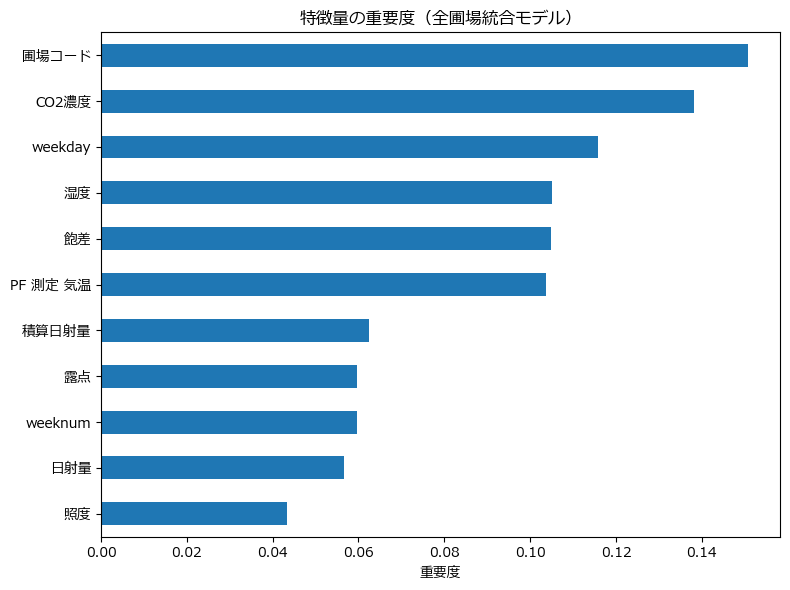

In [10]:
importances = model.feature_importances_
features = pd.Series(importances, index=feature_cols).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
features.plot(kind="barh")
plt.title("特徴量の重要度（全圃場統合モデル）")
plt.xlabel("重要度")
plt.tight_layout()
plt.show()

# 4 ロジスティック成長モデルの作成

## 4-1 ライブラリの読み込み

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 4-2 モデル作成

### ロジスティック関数定義

$ H(t) = \dfrac{K}{1 + e^{-r(t-t_0)}} $

In [14]:
def logistic(t, K, r, t0):
    return K / (1 + np.exp(-r * (t - t0)))

### データ準備

In [7]:
df_all = pd.read_csv("data/tsuji/shaped/processed_青ネギ成長データ.csv")

df_all.head()

,date,株番号,field_name,height_cm,growth_delta,PF 測定 気温,湿度,CO2濃度,照度,日射量,飽差,露点,積算日射量,growth_tomorrow,weekday,weeknum,圃場名
0,2024-08-13,1,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33,12号棟
1,2024-08-13,2,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33,12号棟
2,2024-08-13,3,12号棟,10.0,-35.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,10.0,1,33,12号棟
3,2024-08-20,1,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,7.0,1,34,12号棟
4,2024-08-20,2,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,6.0,1,34,12号棟


In [15]:
days = np.array([0, 5, 10, 15, 20, 25, 30])
heights = np.array([5, 12, 25, 40, 55, 62, 64])

### フィッティング

In [16]:
popt, _ = curve_fit(logistic, days, heights, p0=[65, 0.3, 15])

### 結果プロット

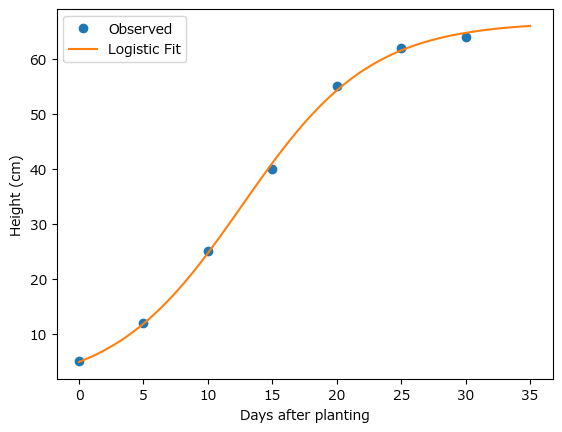

In [17]:
t_fit = np.linspace(0, 35, 100)
h_fit = logistic(t_fit, *popt)
plt.plot(days, heights, 'o', label="Observed")
plt.plot(t_fit, h_fit, '-', label="Logistic Fit")
plt.xlabel("Days after planting")
plt.ylabel("Height (cm)")
plt.legend()
plt.show()

# 5 積算温度を使ったモデル

## 5-1 ライブラリの読み込み

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Meiryo'
from scipy.optimize import curve_fit
import seaborn as sns

## 5-2 データ準備

In [9]:
df_all = pd.read_csv("data/tsuji/shaped/processed_青ネギ成長データ.csv")

df_all.head()

,date,plant_id,field_name,height_cm,growth_delta,temp_pf,humidity,co2,illuminance,solar_radiation,vapor_pressure_deficit,dew_point,solar_radiation_cumsum,growth_tomorrow,weekday,weeknum
0,2024-08-13,1,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33
1,2024-08-13,2,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33
2,2024-08-13,3,12号棟,10.0,-35.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,10.0,1,33
3,2024-08-20,1,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,7.0,1,34
4,2024-08-20,2,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,6.0,1,34


In [10]:
# 日付順にソート
df = df_all.sort_values(by=["field_name", "plant_id", "date"])
df.head()

,date,plant_id,field_name,height_cm,growth_delta,temp_pf,humidity,co2,illuminance,solar_radiation,vapor_pressure_deficit,dew_point,solar_radiation_cumsum,growth_tomorrow,weekday,weeknum
0,2024-08-13,1,12号棟,9.0,-37.0,29.314635,79.831545,445.650521,13.902778,815484,7.080451,25.117292,21.44082,9.0,1,33
3,2024-08-20,1,12号棟,18.0,9.0,28.627293,83.085754,454.380299,12.659312,742633,5.861362,25.134746,17.60790,7.0,1,34
6,2024-08-27,1,12号棟,25.0,7.0,30.252847,72.237934,429.247049,12.786458,750350,9.228854,24.472188,18.14778,10.0,1,35
9,2024-09-03,1,12号棟,35.0,10.0,26.659913,83.635330,450.175694,9.626215,567353,4.795503,23.400590,11.98596,-27.0,1,36
12,2024-09-10,1,12号棟,46.0,24.0,29.304549,75.301667,449.337674,12.800000,750786,8.544583,24.040399,20.74776,-28.0,1,37


## 5-3 積算日射量と草丈の関係

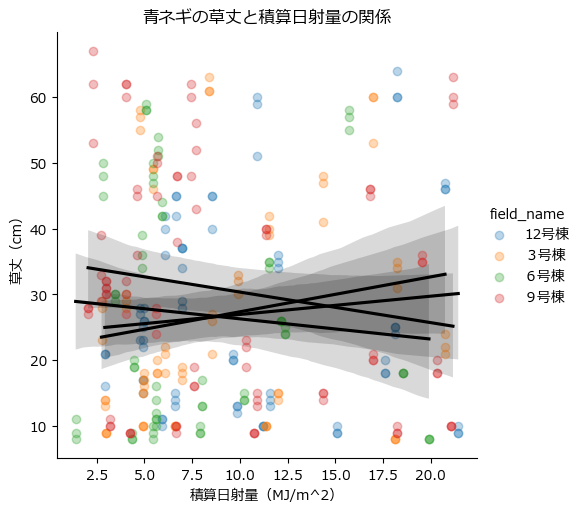

In [11]:
sns.lmplot(
    data=df,
    x="solar_radiation_cumsum",
    y="height_cm",
    hue="field_name",
    scatter_kws={"alpha": 0.3},
    line_kws={"color": "black"}
)
plt.title("青ネギの草丈と積算日射量の関係")
plt.xlabel("積算日射量（MJ/m^2）")
plt.ylabel("草丈（cm）")
plt.show()

## 5-4 成長モデルの構築（ロジスティック関数による曲線あてはめ）

In [12]:
from scipy.optimize import curve_fit
import numpy as np

#### 積算温度GDD（Growing Degree Days）の定義

$ GDD = \displaystyle\sum_{i=1}^{t} max\left( \dfrac{T_{max, \ i} + T_{min, \ i}}{2} - T_{base}, \ 0 \right) $

（$T_{max, \ i}$：$i$日目の最高気温、$T_{min, \ i}$：$i$日目の最低気温、$T_{base}$：基準温度（青ネギなら通常5~10℃））

#### ロジスティック成長モデル（S字型）

$ H(t) = \dfrac{K}{1 + e^{-r(t-t_0)}} $

（$K$：最大草丈、$r$：成長速度、$t_0$：急成長開始日）

In [13]:
def logistic(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

### 個体ごとに曲線フィッティングしてパラメータを取得（例として一本）

In [14]:
sample = df[(df["field_name"] == "12号棟") & (df["plant_id"] == 1)]
xdata = sample["solar_radiation_cumsum"].values
ydata = sample["height_cm"].values

### 初期値とフィッティング

In [15]:
p0 = [200, 100, 65]  # a, b, cの初期推定
params, _ = curve_fit(logistic, xdata, ydata, p0=p0)

### パラメータを表示

In [16]:
print("フィットしたパラメータ（a, b, c）：", params)

フィットしたパラメータ（a, b, c）： [ 1.55453925  1.82624956 27.81143887]


### プロット

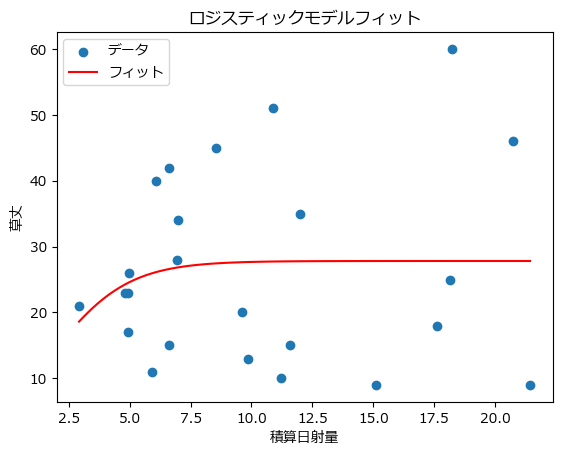

In [18]:
x_fit = np.linspace(min(xdata), max(xdata), 100)
y_fit = logistic(x_fit, *params)

plt.scatter(xdata, ydata, label="データ")
plt.plot(x_fit, y_fit, color="red", label="フィット")
plt.xlabel("積算日射量")
plt.ylabel("草丈")
plt.title("ロジスティックモデルフィット")
plt.legend()
plt.show()